In [100]:
%pip install tf_keras_vis tflite-support-nightly

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tflite-support-nightly (from versions: none)
ERROR: No matching distribution found for tflite-support-nightly


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [101]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [102]:
train_df = create_dataframe_from_directories("dataset_train")
test_df = create_dataframe_from_directories("dataset_test")

all_df = pd.concat([train_df, test_df])

In [103]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['cylinder', 'dimple', 'laser track', 'mortice'], dtype=object)

**TODO**: Display some images of your dataset

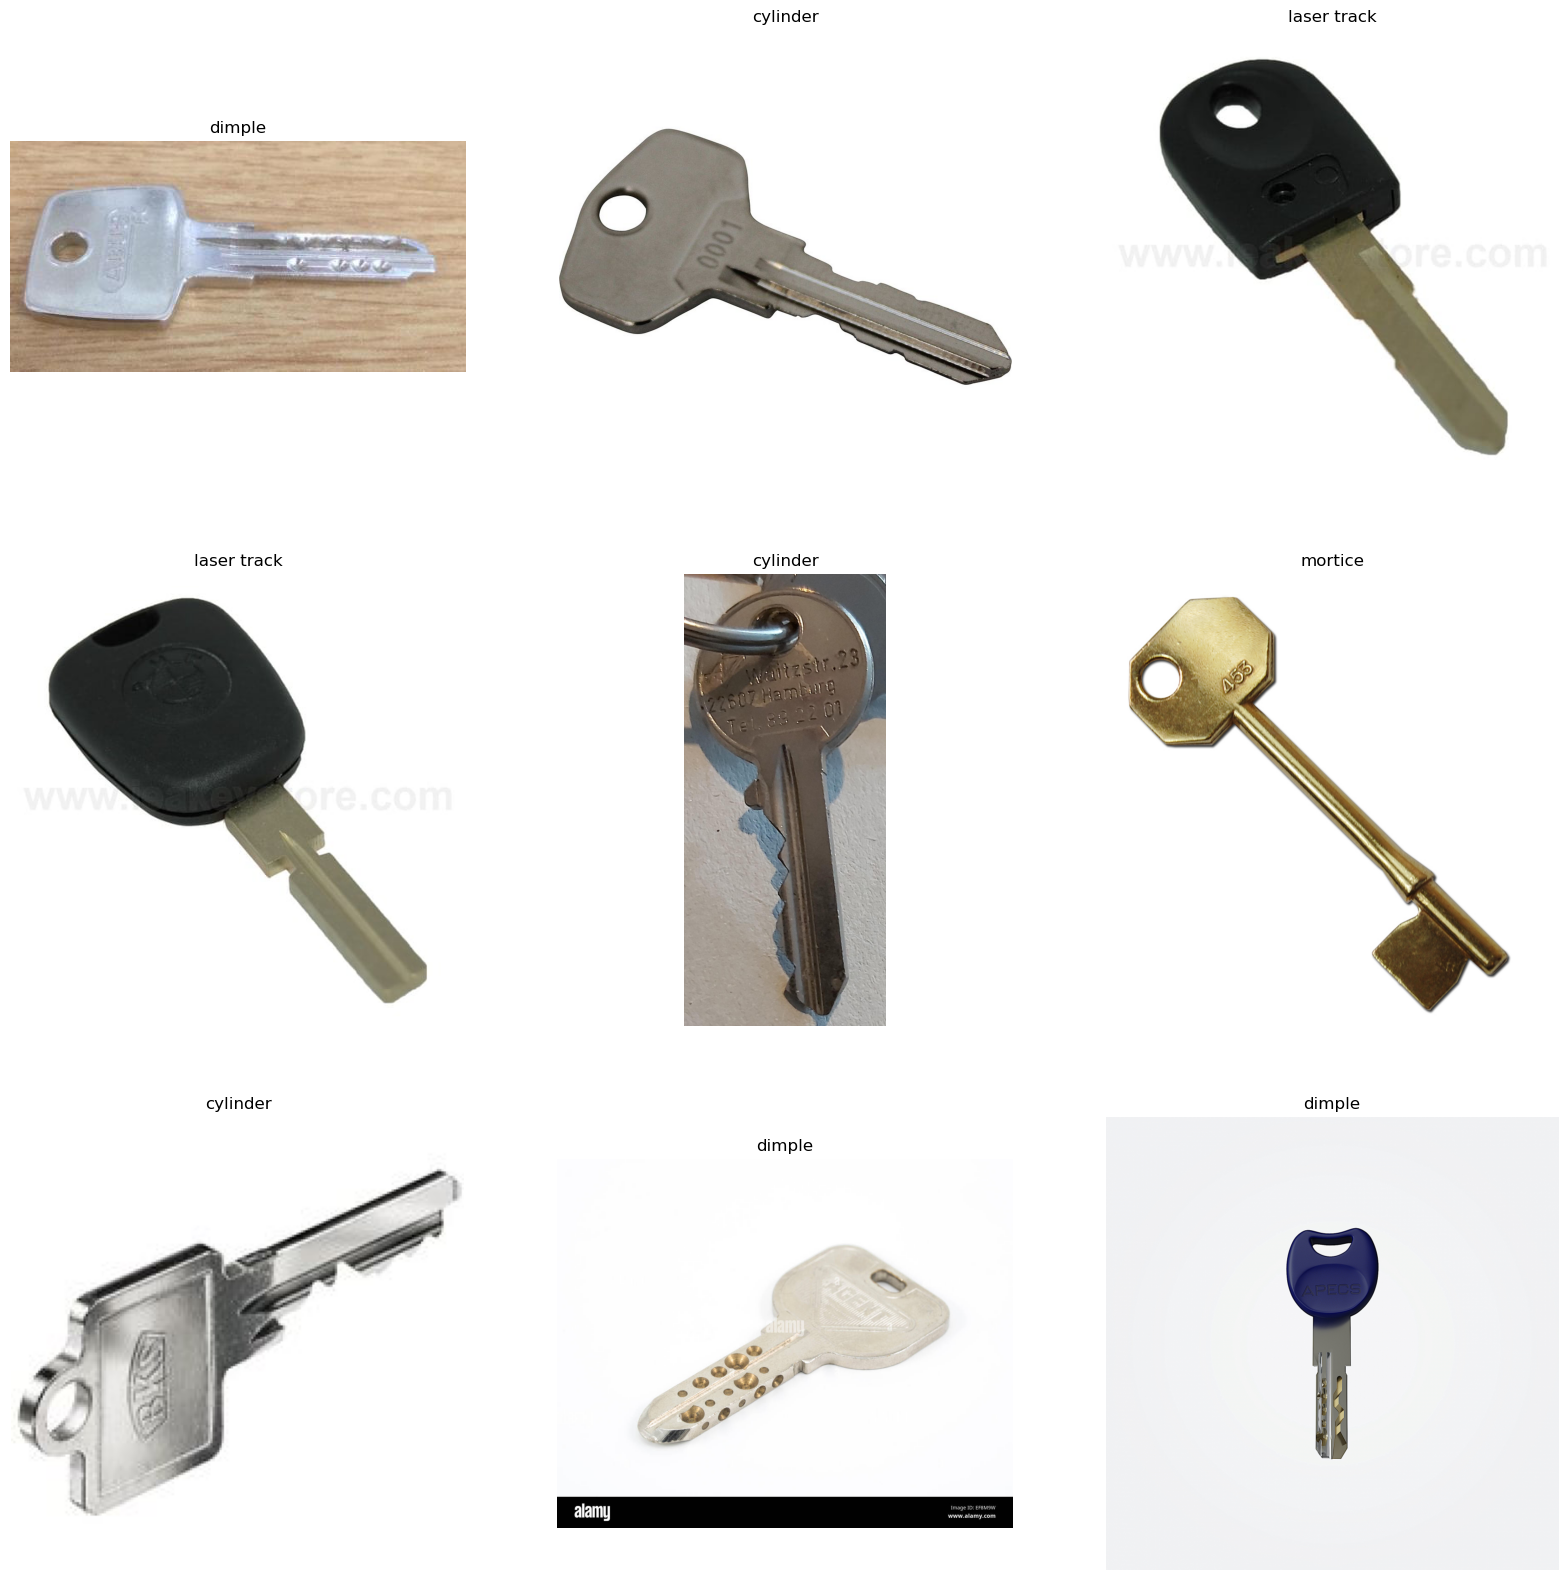

In [104]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in all_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

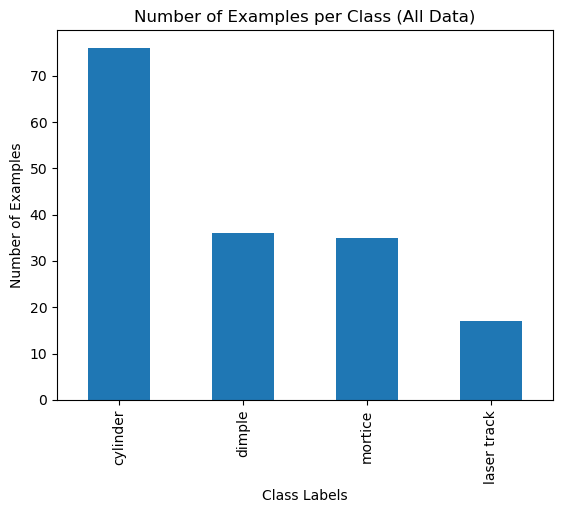

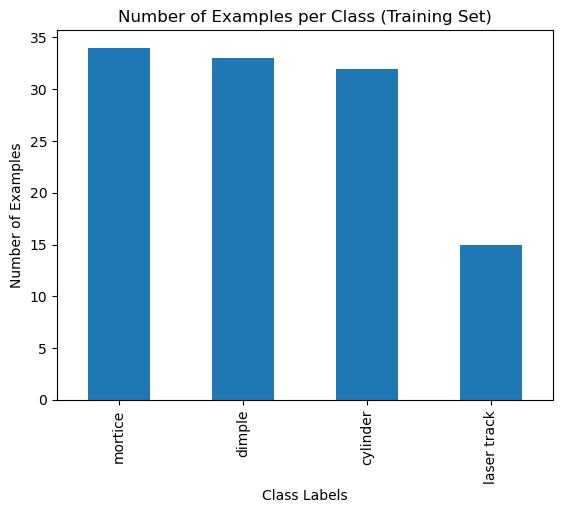

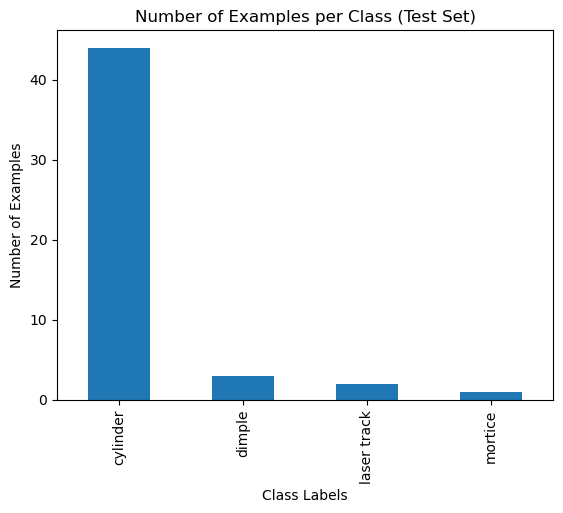

In [153]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

def plot_class_distribution(df, title):
    class_counts = df['label'].value_counts()
    class_counts.plot(kind='bar')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Examples')
    plt.title(title)
    plt.show()

# Plot for all data
plot_class_distribution(all_df, 'Number of Examples per Class (All Data)')

# Plot for the training set
plot_class_distribution(train_df, 'Number of Examples per Class (Training Set)')

# Plot for the test set
plot_class_distribution(test_df, 'Number of Examples per Class (Test Set)')

# Preprocessing steps

In [106]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom
)

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation

    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

def open_images(paths):
    images = []
    for path in paths:
        img = open_image(path)
        if img is not None:
            images.append(img)
    return np.stack(images)

def open_image(path):
    try:
        image = PIL.Image.open(path).convert('RGB')  # Ensure image is RGB
        image = np.asarray(image)
        image = image_preprocesses(image)
        return image
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

**TODO**: plot examples of preprocessed and augmented images

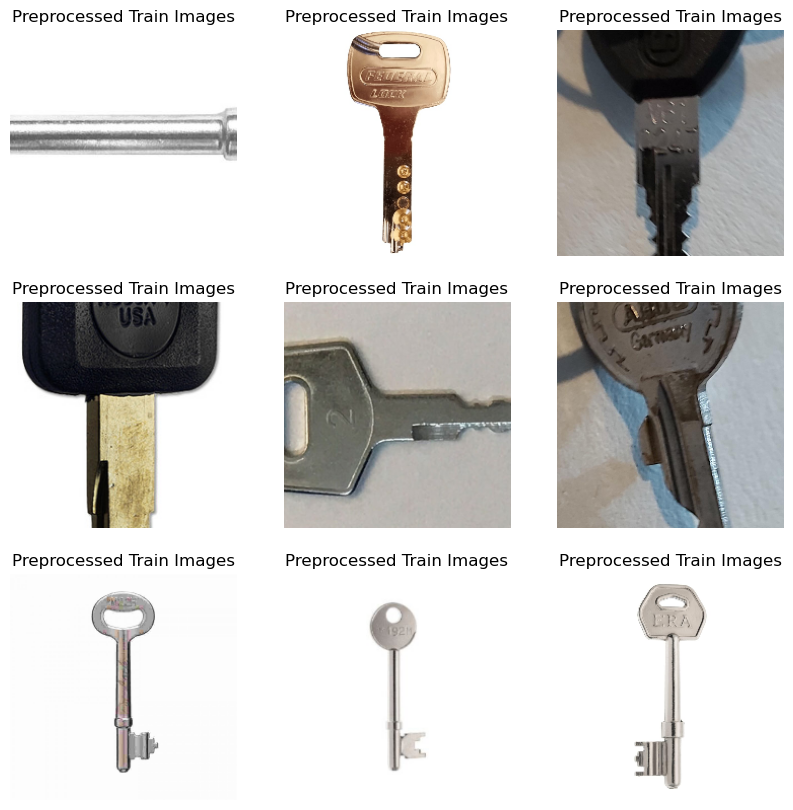

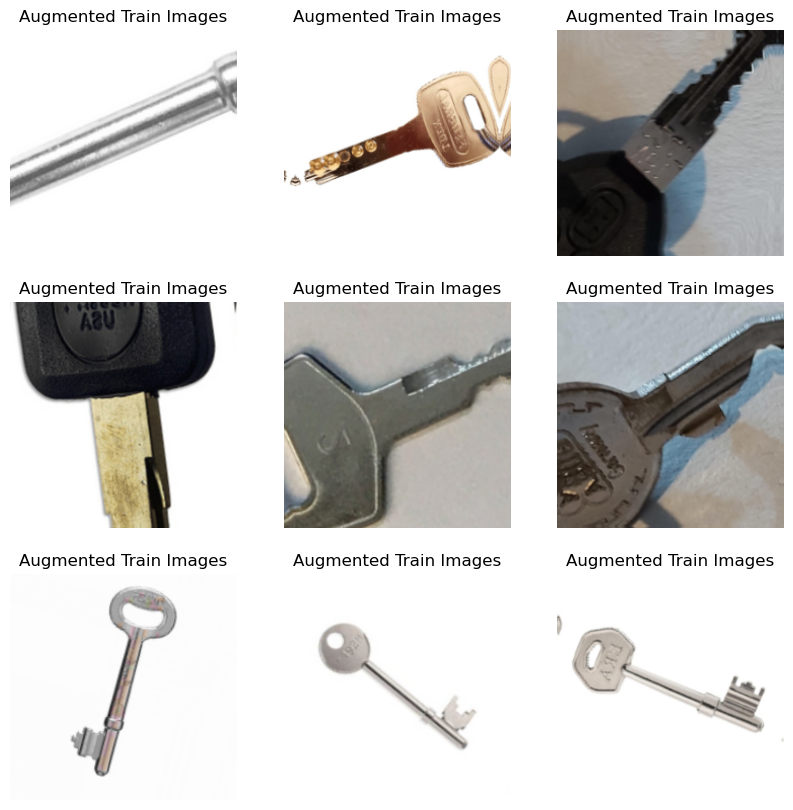

In [107]:
import matplotlib.pyplot as plt

def plot_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis("off")
    plt.show()

# Select a few images at random
random_images = all_df.sample(n=9)['path'].tolist()

# Preprocess and augment images
preprocessed_images = open_images(random_images)
augmented_images = augment_images(preprocessed_images)


# Plot preprocessed and augmented images for train set
plot_images(preprocessed_images, title='Preprocessed Train Images')
plot_images(augmented_images, title='Augmented Train Images')

In [108]:
# Open every image in the dataset to make sure they are all valid
all_df['image'] = all_df['path'].apply(open_image)

## Define model

In [109]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        Dense(64, activation='relu'),
        Dense(len(LABEL_NAMES), activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [110]:
get_model().summary()

Model: "functional_306"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_92      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_92[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,228 (8.93 MB)

 Trainable params: 82,244 (321.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [111]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

total_train_paths = shuffled_dataset['path'].to_numpy()
total_train_labels = shuffled_dataset['label'].to_numpy()

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(total_train_labels)
total_train_labels = label_encoder.transform(total_train_labels)

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
models = []
histories = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]

    # Apply data augmentation to training images
    augmented_train_images = augment_images(train_images)
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=augmented_train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])
    models.append(model)
    histories.append(history)

Epoch 1/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 909ms/step - acc: 0.2538 - loss: 1.8293 - val_acc: 0.6957 - val_loss: 0.9480
Epoch 2/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - acc: 0.7204 - loss: 0.8616 - val_acc: 0.6522 - val_loss: 0.9637
Epoch 3/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step - acc: 0.8536 - loss: 0.5631 - val_acc: 0.8261 - val_loss: 0.7232
Epoch 4/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - acc: 0.8646 - loss: 0.4346 - val_acc: 0.7826 - val_loss: 0.6332
Epoch 1/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 889ms/step - acc: 0.4174 - loss: 1.5807 - val_acc: 0.5217 - val_loss: 1.2390
Epoch 2/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - acc: 0.6514 - loss: 0.7588 - val_acc: 0.7391 - val_loss: 0.5985
Epoch 3/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - acc: 0.8880 - loss: 0.4497 - val_acc: 0.6087 - val_loss: 0.7886
Epoch 4/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - acc: 0.7932 - loss: 0.4656 - val_acc: 0.7391 - val_loss: 0.6077
Epoch 1/4
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 918ms/step - acc: 0.2975 - loss: 2.1443 - 

# Results

**TODO**: plot the results from your crossvalidation

In [112]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


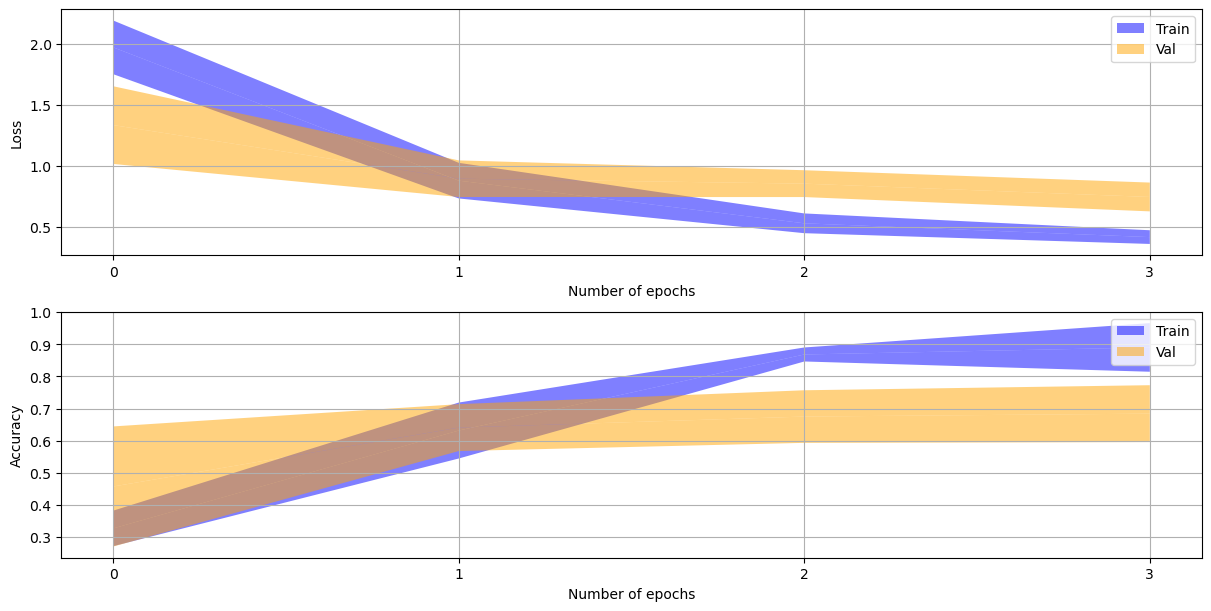

In [113]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [144]:
import sklearn.metrics as me

# Choose the best model of the 5 trained
best_model = models[np.argmax([history.history['val_acc'][-1] for history in histories])]

total_test_paths = test_df['path'].to_numpy()
total_test_labels = test_df['label'].to_numpy()

total_test_labels = label_encoder.transform(total_test_labels)

test_images = open_images(total_test_paths)    

pred = best_model.predict(test_images)
pred = np.argmax(pred, axis=-1)

# Convert test labels and predictions to integer numpy arrays
total_test_labels = np.array(total_test_labels).astype(int)
pred = np.array(pred).astype(int)

# Ensure LABEL_NAMES is correctly mapped to integer labels
label_mapping = {name: idx for idx, name in enumerate(LABEL_NAMES)}

test_confusion_matrix = me.confusion_matrix(total_test_labels, pred, labels=np.arange(len(LABEL_NAMES)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


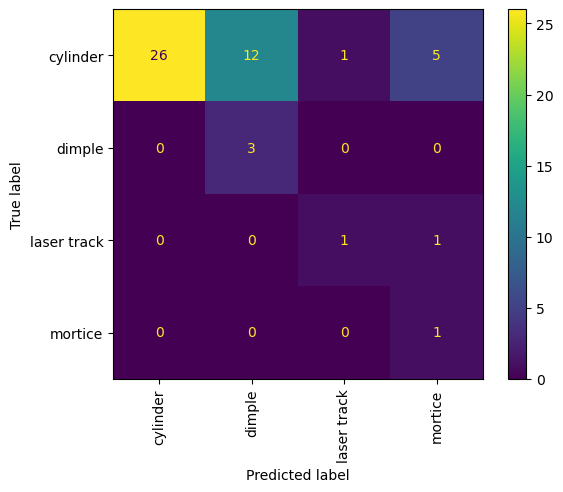

In [137]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=LABEL_NAMES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()

In [138]:
import sklearn.metrics as me

# Compute F-scores
f1_scores = me.f1_score(total_test_labels, pred, labels=np.arange(len(LABEL_NAMES)), average=None)
average_f1_score = me.f1_score(total_test_labels, pred, labels=np.arange(len(LABEL_NAMES)), average='weighted')

# Print F-scores
for idx, label in enumerate(LABEL_NAMES):
    print(f'F1-score for {label}: {f1_scores[idx]}')
print(f'Weighted average F1-score: {average_f1_score}')

F1-score for cylinder: 0.7428571428571429
F1-score for dimple: 0.33333333333333337
F1-score for laser track: 0.5
F1-score for mortice: 0.25
Weighted average F1-score: 0.6987142857142856


### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

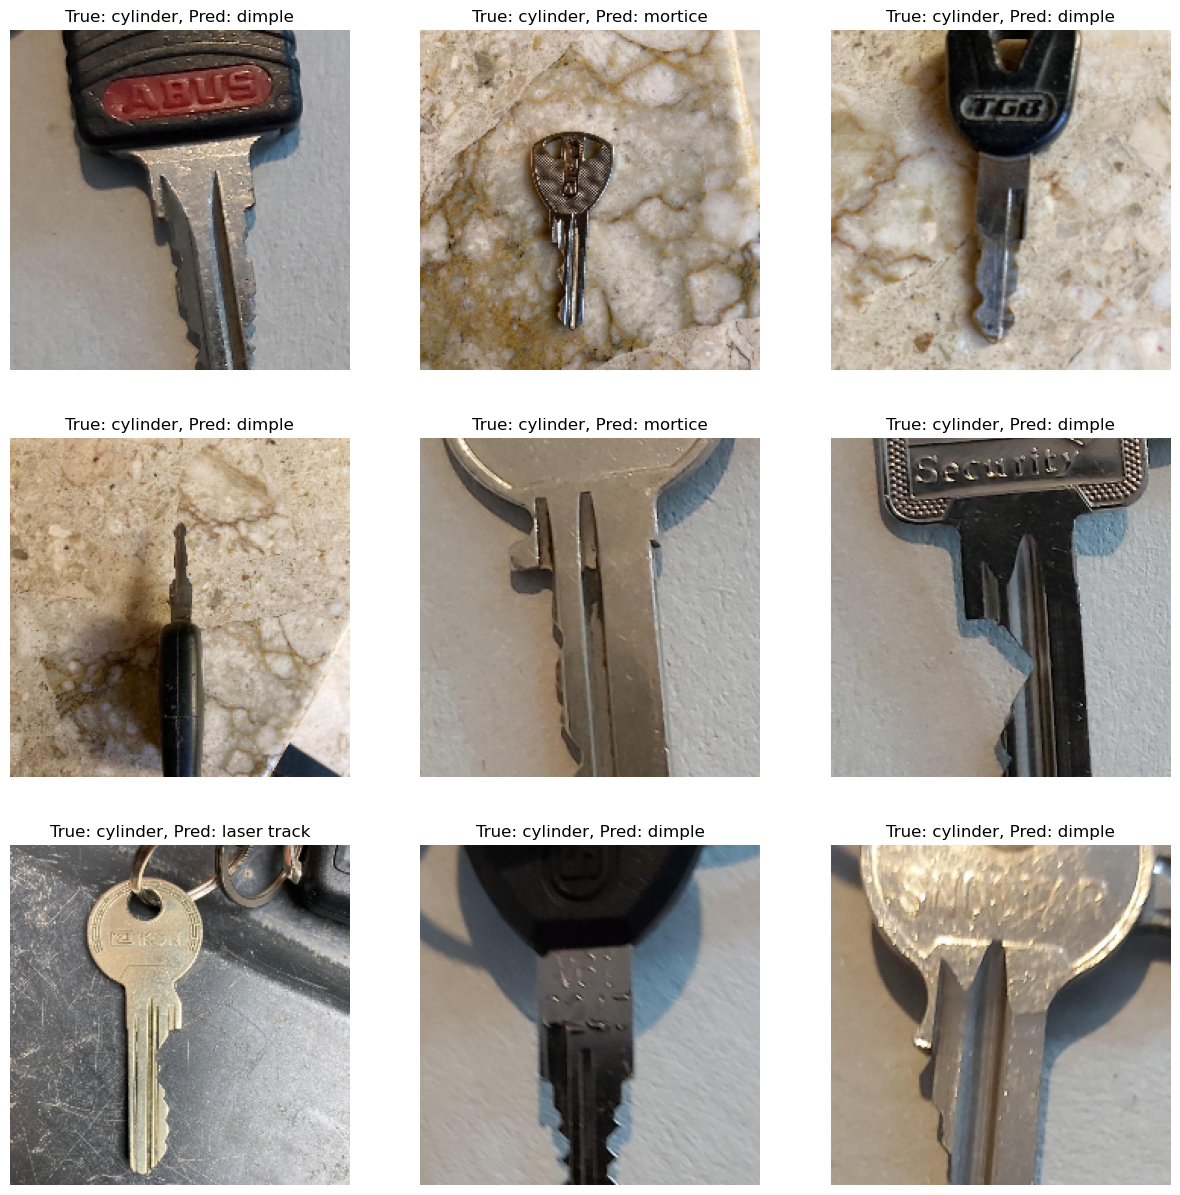

In [139]:
# Identify misclassified images
misclassified_indices = np.where(total_test_labels != pred)[0]
misclassified_paths = total_test_paths[misclassified_indices]
misclassified_true_labels = total_test_labels[misclassified_indices]
misclassified_pred_labels = pred[misclassified_indices]

# Display some misclassified images
def display_misclassified_images(paths, true_labels, pred_labels, label_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(paths))):
        img_path = paths[i]
        true_label = label_names[true_labels[i]]
        pred_label = label_names[pred_labels[i]]
        img = open_image(img_path)
        if img is not None:
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(f'True: {true_label}, Pred: {pred_label}')
            plt.axis('off')
    plt.show()

# Display misclassified images
display_misclassified_images(misclassified_paths, misclassified_true_labels, misclassified_pred_labels, LABEL_NAMES)

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

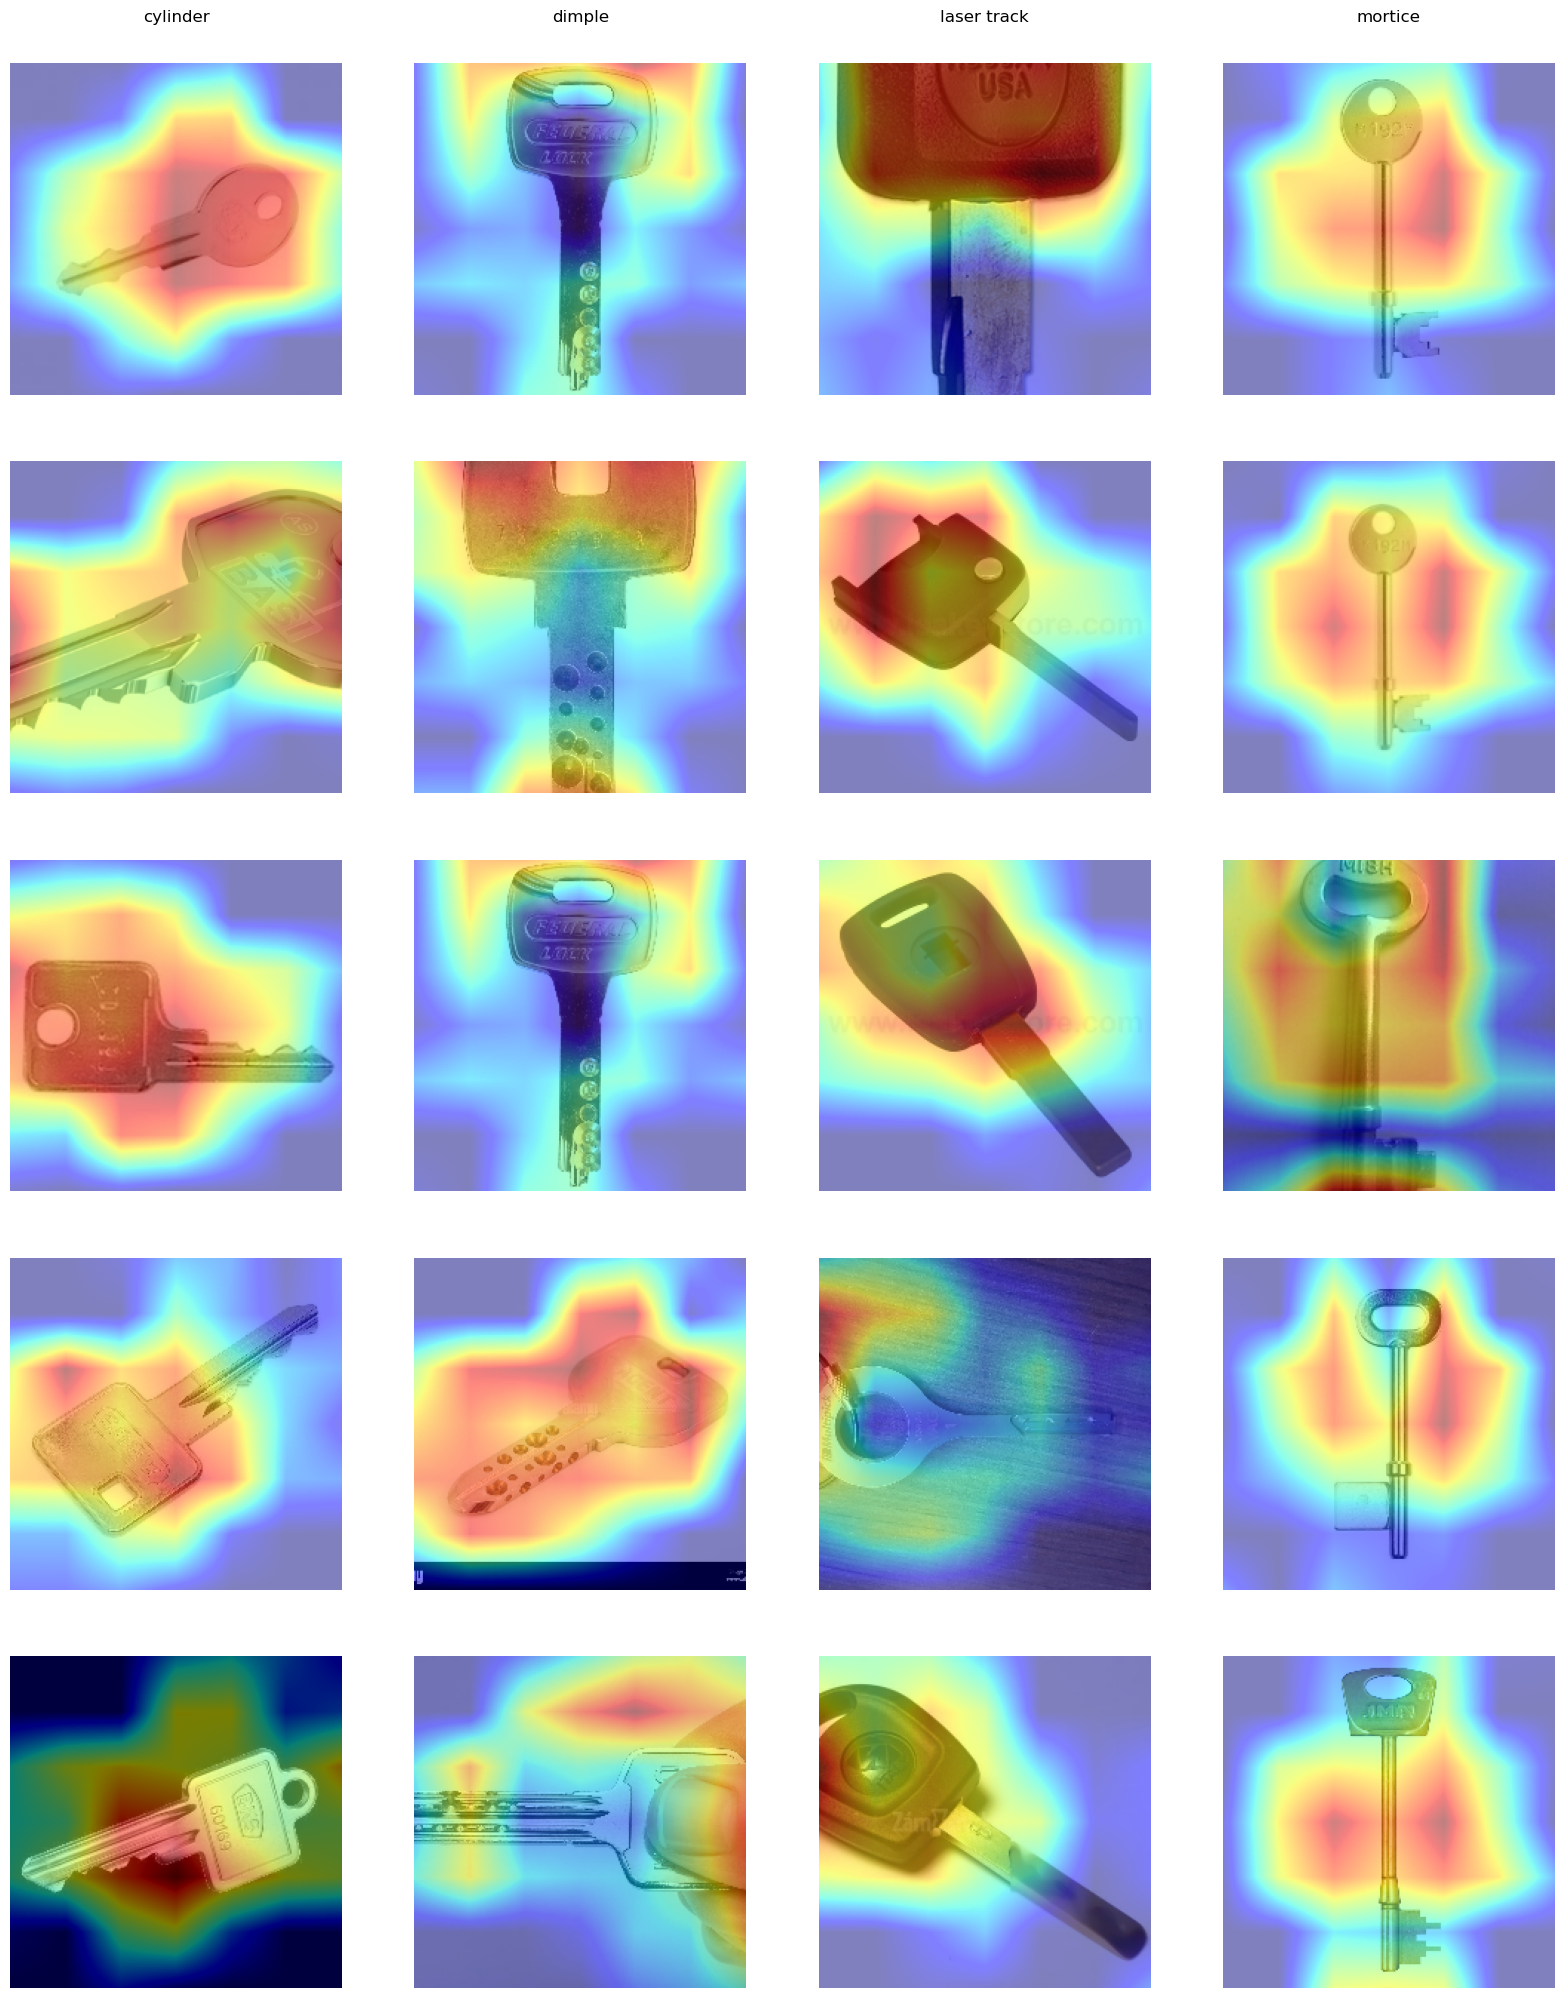

In [140]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 5

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

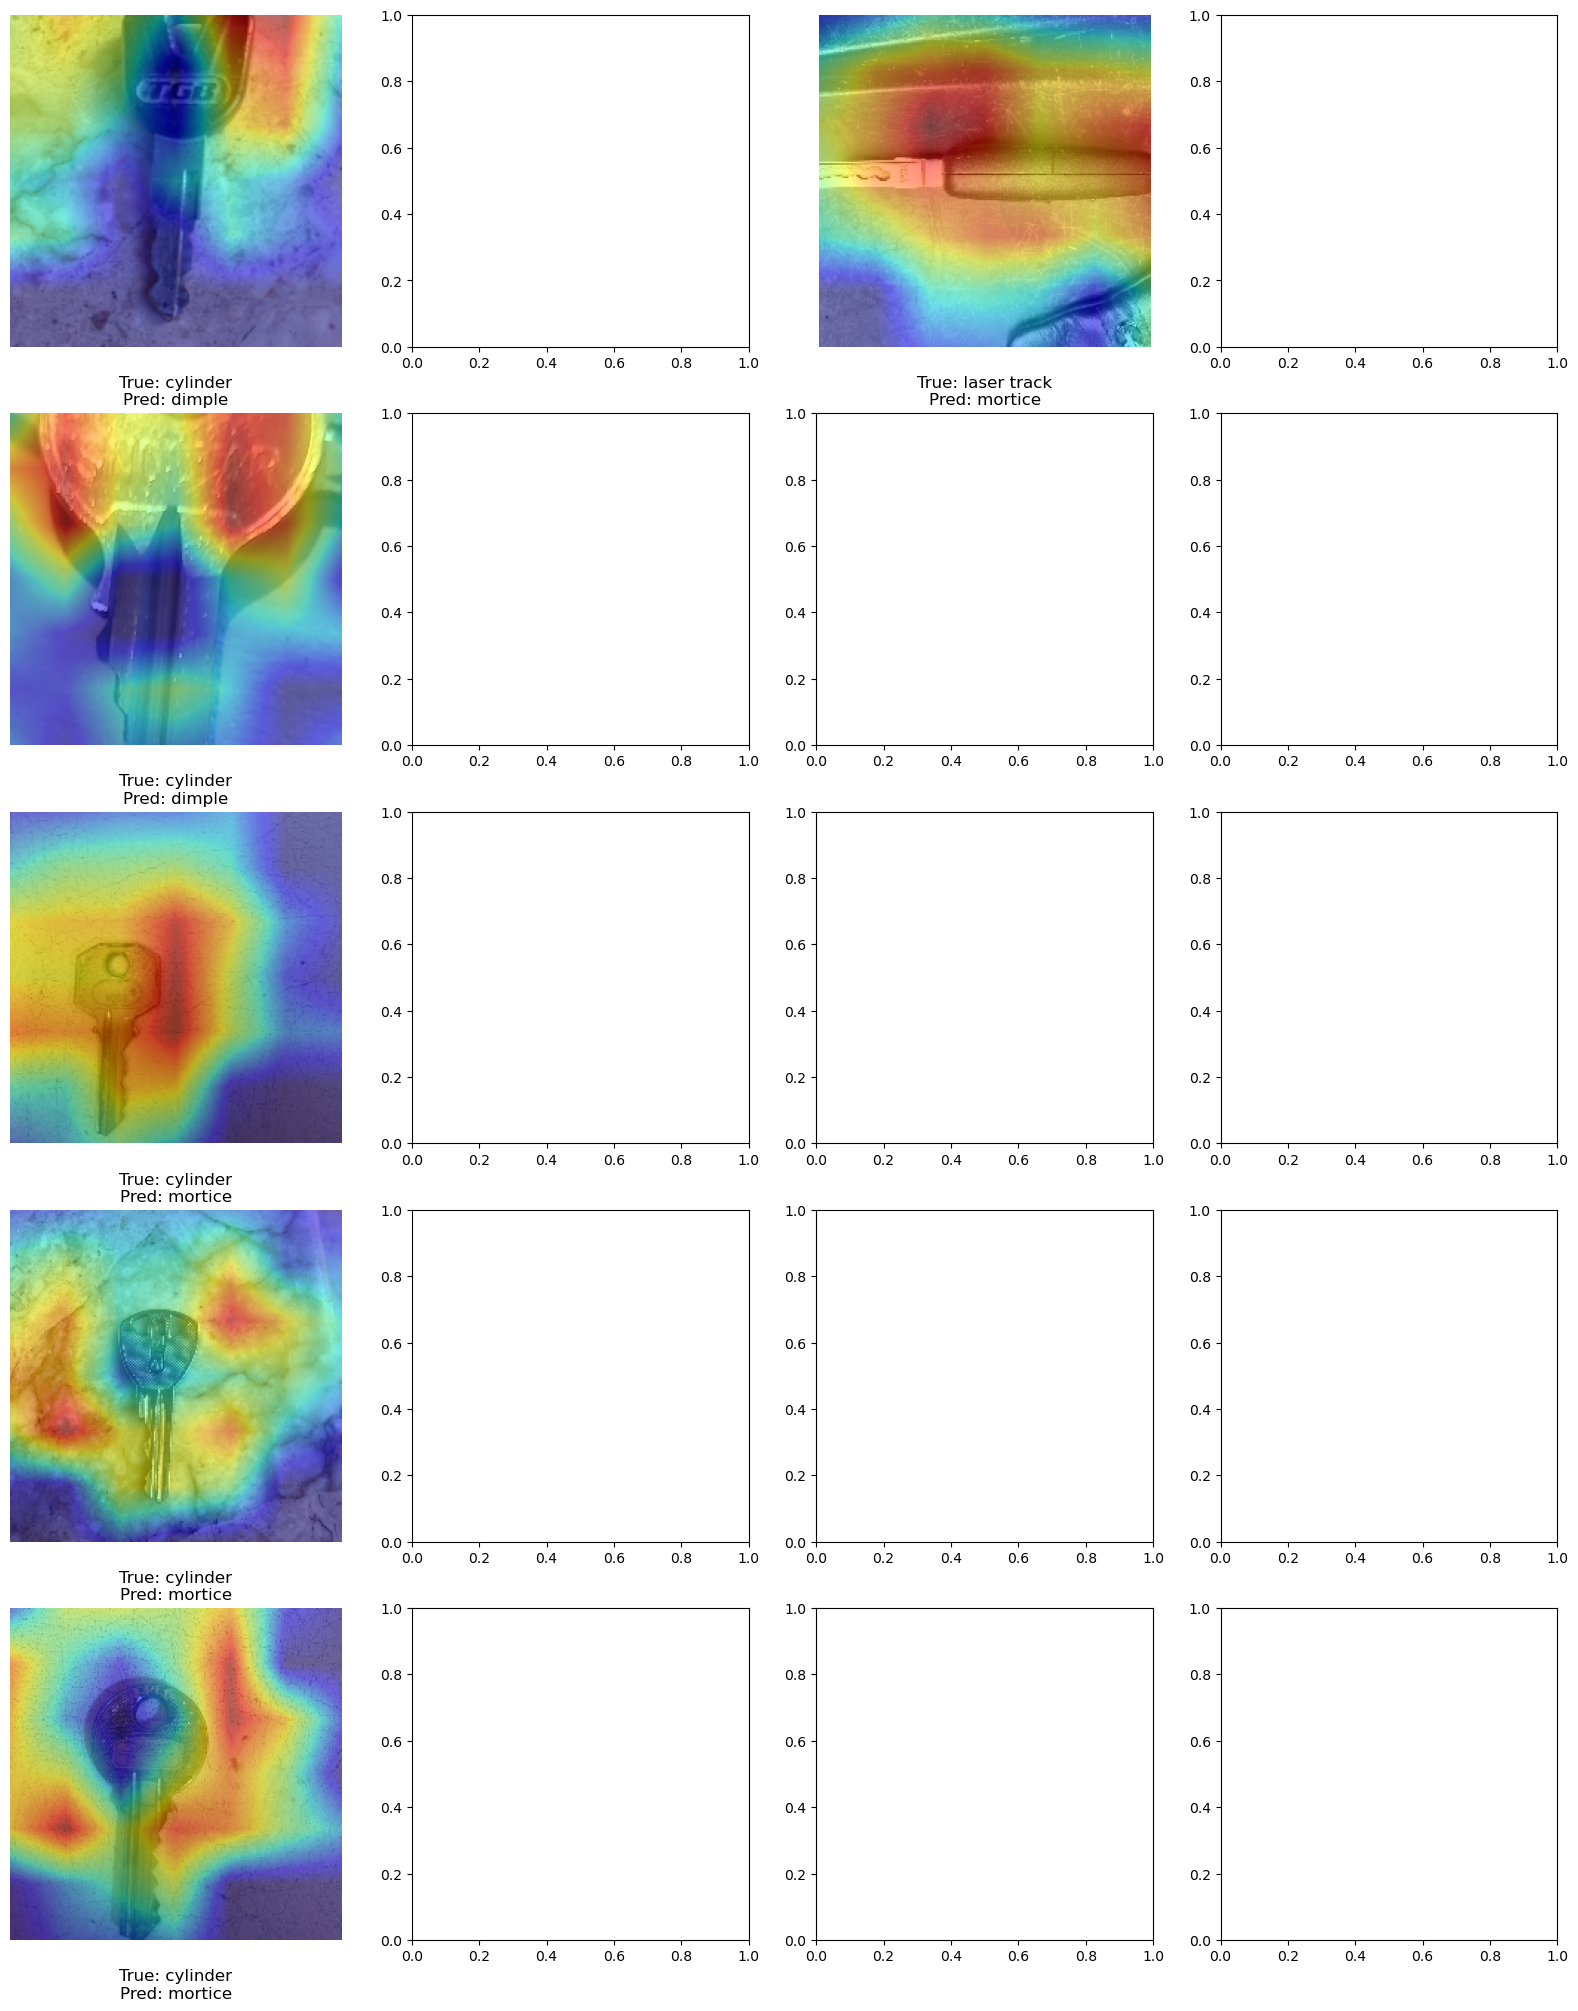

In [152]:
# Number of misclassified images to visualize per class
nb_images_per_class = 5

# Identify misclassified images
misclassified_indices = np.where(total_test_labels != pred)[0]
misclassified_paths = total_test_paths[misclassified_indices]
misclassified_true_labels = total_test_labels[misclassified_indices]
misclassified_pred_labels = pred[misclassified_indices]

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    
    # Get misclassified images for this label
    indices = [i for i, true_label in enumerate(misclassified_true_labels) if true_label == label_idx]
    sample_indices = np.random.choice(indices, nb_images_per_class, replace=False) if len(indices) > nb_images_per_class else indices

    for i, idx in enumerate(sample_indices):
        img_path = misclassified_paths[idx]
        img = open_image(img_path)    
        pred_label = LABEL_NAMES[misclassified_pred_labels[idx]]

        # Generate cam with GradCAM++
        score = CategoricalScore(misclassified_pred_labels[idx])
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i, label_idx].imshow(img, vmin=0, vmax=1)
        axs[i, label_idx].imshow(heatmap, cmap='jet', alpha=0.5)  # overlay
        axs[i, label_idx].set_title(f'True: {label_name}\nPred: {pred_label}', loc='center', y=-0.2)
        axs[i, label_idx].axis("off")


**TODO**: try to determine what caused the misclassifcations and what you can do about it